In [2]:
#important to have the correct version of sklearn 0.23.1 and correct version of joblib 1.2.0
!pip show joblib

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: 
Required-by: nltk, scikit-learn


In [3]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.23.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sagemaker-data-insights, smclarify


In [4]:
!pip install --upgrade scikit-learn==0.23.1


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
%%html
Steps</br>
#1) Download the movie data sets available in the s3 bucket to the sagemaker notebook environment. </br>
#2) Start analyzing the data

In [6]:
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket_name='movierecommender-477713232171'

title_basic = 'csv_files/title.basics.tsv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket = bucket_name,Key = title_basic)

df_title_basic = pd.read_table(obj['Body'])
df_title_basic = df_title_basic.dropna()
df_title_basic.head()


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short

In [7]:
print("finding the unique columns in the data set \n")
print(df_title_basic.nunique(axis=0))

print("Explore how many media items are in each title types \n")
print(df_title_basic.groupby('titleType')['tconst'].nunique())

# Cleanup steps - Consider only those titles which are movies
title_basics_processed = df_title_basic[df_title_basic['titleType']=='movie']

# Cleanup steps - We dont need end year for this data set
title_basics_processed = title_basics_processed.drop(columns = "endYear")

#Cleanup steps - We dont need titleType since we are only interested in one type of titles
title_basics_processed = title_basics_processed.drop(columns = "titleType" )

title_basics_processed.head()

finding the unique columns in the data set 

tconst            9469926
titleType              11
primaryTitle      4323477
originalTitle     4344438
isAdult                 4
startYear             151
endYear                97
runtimeMinutes        879
genres               2337
dtype: int64
Explore how many media items are in each title types 

titleType
movie            630450
short            905311
tvEpisode       7160585
tvMiniSeries      46498
tvMovie          139698
tvPilot               2
tvSeries         235986
tvShort            9849
tvSpecial         39750
video            268664
videoGame         33133
Name: tconst, dtype: int64


tconst                   primaryTitle                  originalTitle  \
8    tt0000009                     Miss Jerry                     Miss Jerry   
144  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
498  tt0000502                       Bohemios                       Bohemios   
570  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
587  tt0000591               The Prodigal Son              L'enfant prodigue   

    isAdult startYear runtimeMinutes                      genres  
8         0      1894             45                     Romance  
144       0      1897            100      Documentary,News,Sport  
498       0      1905            100                          \N  
570       0      1906             70  Action,Adventure,Biography  
587       0      1907             90                       Drama

In [8]:
title_basics_processed = title_basics_processed[title_basics_processed.isAdult == 0]
title_basics_processed.groupby('isAdult').size()
title_basics_processed = title_basics_processed.drop(columns = "isAdult" )

In [9]:
#Some more cleanup process for the data set  to get rid of invalid values of start year
title_basics_processed.groupby('startYear').size()

startYear
1894        1
1896        1
1897        2
1898        7
1899        8
        ...  
2025       47
2026       12
2027        5
2028        2
\N      84653
Length: 135, dtype: int64

In [10]:
title_basics_processed = title_basics_processed[title_basics_processed.startYear != '\\N']
title_basics_processed.groupby('startYear').size()

startYear
1894      1
1896      1
1897      2
1898      7
1899      8
       ... 
2024    192
2025     47
2026     12
2027      5
2028      2
Length: 134, dtype: int64

In [11]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533548 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          533548 non-null  object
 1   primaryTitle    533548 non-null  object
 2   originalTitle   533548 non-null  object
 3   startYear       533548 non-null  object
 4   runtimeMinutes  533548 non-null  object
 5   genres          533548 non-null  object
dtypes: object(6)
memory usage: 28.5+ MB


In [12]:
#Convert the date to numeric value so that you can do some kind of exploratory analysis
title_basics_processed['startYear'] = pd.to_datetime(title_basics_processed['startYear'], format='%Y').dt.year

In [13]:
title_basics_processed.head()

tconst                   primaryTitle                  originalTitle  \
8    tt0000009                     Miss Jerry                     Miss Jerry   
144  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
498  tt0000502                       Bohemios                       Bohemios   
570  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
587  tt0000591               The Prodigal Son              L'enfant prodigue   

     startYear runtimeMinutes                      genres  
8         1894             45                     Romance  
144       1897            100      Documentary,News,Sport  
498       1905            100                          \N  
570       1906             70  Action,Adventure,Biography  
587       1907             90                       Drama

In [14]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533548 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          533548 non-null  object
 1   primaryTitle    533548 non-null  object
 2   originalTitle   533548 non-null  object
 3   startYear       533548 non-null  int64 
 4   runtimeMinutes  533548 non-null  object
 5   genres          533548 non-null  object
dtypes: int64(1), object(5)
memory usage: 28.5+ MB


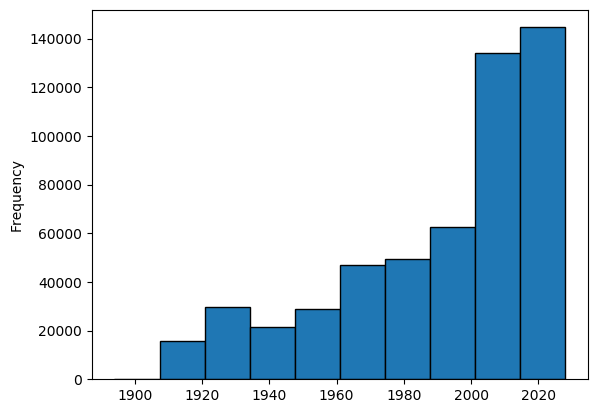

In [15]:
%matplotlib inline
title_basics_processed['startYear'].plot(kind='hist', edgecolor='black')

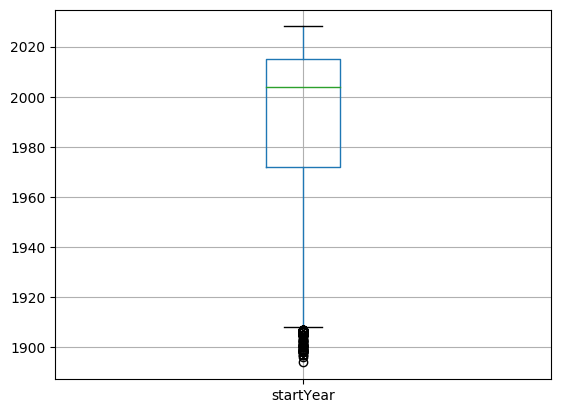

In [16]:
%matplotlib inline
# Some more detail , lets do a box plot to find the percentile distribution 
# and quartile ranges to figure out the distribution
title_basics_processed.boxplot(column='startYear', return_type='axes');

In [17]:
#clean up start year values
print(title_basics_processed['startYear'].quantile(0.10))
print(title_basics_processed['startYear'].quantile(0.90))
print(title_basics_processed['startYear'].skew())

1938.0
2020.0
-0.995550735279642


In [18]:
import numpy as np
# A strategy for imputation
title_basics_processed["startYear"] = np.where(title_basics_processed["startYear"] <1938.0, 1938.0,title_basics_processed['startYear'])
title_basics_processed["startYear"] = np.where(title_basics_processed["startYear"] >2020.0, 2020.0,title_basics_processed['startYear'])
print(title_basics_processed['startYear'].skew())

-0.7954828274994374


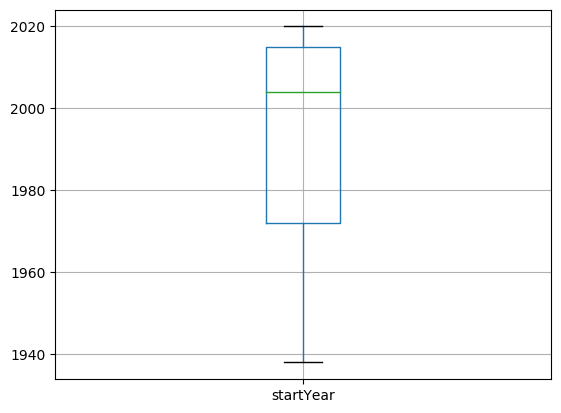

In [19]:
%matplotlib inline
#the distribution of data now looks better
title_basics_processed.boxplot(column='startYear', return_type='axes');

In [20]:
#Convert year to float
title_basics_processed.startYear = title_basics_processed.startYear.apply(int)
title_basics_processed.head()

tconst                   primaryTitle                  originalTitle  \
8    tt0000009                     Miss Jerry                     Miss Jerry   
144  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
498  tt0000502                       Bohemios                       Bohemios   
570  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
587  tt0000591               The Prodigal Son              L'enfant prodigue   

     startYear runtimeMinutes                      genres  
8         1938             45                     Romance  
144       1938            100      Documentary,News,Sport  
498       1938            100                          \N  
570       1938             70  Action,Adventure,Biography  
587       1938             90                       Drama

In [21]:
title_basics_processed['runtimeMinutes'] = pd.to_numeric(title_basics_processed['runtimeMinutes'],errors='coerce')
title_basics_processed.dropna()

tconst                                       primaryTitle  \
8        tt0000009                                         Miss Jerry   
144      tt0000147                      The Corbett-Fitzsimmons Fight   
498      tt0000502                                           Bohemios   
570      tt0000574                        The Story of the Kelly Gang   
587      tt0000591                                   The Prodigal Son   
...            ...                                                ...   
9469796  tt9916538                                Kuambil Lagi Hatiku   
9469837  tt9916622        Rodolpho Teóphilo - O Legado de um Pioneiro   
9469864  tt9916680  De la ilusión al desconcierto: cine colombiano...   
9469887  tt9916730                                             6 Gunn   
9469897  tt9916754                     Chico Albuquerque - Revelações   

                                             originalTitle  startYear  \
8                                               Miss Jerry       1938   
144                          The Corbett-Fitzsimmons Fight       1938   
498                                               Bohemios       1938   
570                            The Story of the Kelly Gang       1938   
587                                      L'enfant prodigue       1938   
...                                                    ...        ...   
9469796                                Kuambil Lagi Hatiku       2019   
9469837        Rodolpho Teóphilo - O Legado de um Pioneiro       2015   
9469864  De la ilusión al desconcierto: cine colombiano...       2007   
9469887                                             6 Gunn       2017   
9469897                     Chico Albuquerque - Revelações       2013   

         runtimeMinutes                      genres  
8                  45.0                     Romance  
144               100.0      Documentary,News,Sport  
498               100.0                          \N  
570                70.0  Action,Adventure,Biography  
587                90.0                       Drama  
...                 ...                         ...  
9469796           123.0                       Drama  
9469837            57.0                 Documentary  
9469864           100.0                 Documentary  
9469887           116.0                          \N  
9469897            49.0                 Documentary  

[384589 rows x 6 columns]

In [22]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533548 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          533548 non-null  object 
 1   primaryTitle    533548 non-null  object 
 2   originalTitle   533548 non-null  object 
 3   startYear       533548 non-null  int64  
 4   runtimeMinutes  384589 non-null  float64
 5   genres          533548 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.5+ MB


In [23]:
title_basics_processed = title_basics_processed.dropna()
title_basics_processed.runtimeMinutes = title_basics_processed.runtimeMinutes.apply(int)
print(title_basics_processed.head())

        tconst                   primaryTitle                  originalTitle  \
8    tt0000009                     Miss Jerry                     Miss Jerry   
144  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
498  tt0000502                       Bohemios                       Bohemios   
570  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
587  tt0000591               The Prodigal Son              L'enfant prodigue   

     startYear  runtimeMinutes                      genres  
8         1938              45                     Romance  
144       1938             100      Documentary,News,Sport  
498       1938             100                          \N  
570       1938              70  Action,Adventure,Biography  
587       1938              90                       Drama  


In [24]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384589 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          384589 non-null  object
 1   primaryTitle    384589 non-null  object
 2   originalTitle   384589 non-null  object
 3   startYear       384589 non-null  int64 
 4   runtimeMinutes  384589 non-null  int64 
 5   genres          384589 non-null  object
dtypes: int64(2), object(4)
memory usage: 20.5+ MB


In [25]:
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes != '\\N']
title_basics_processed.head()

tconst                   primaryTitle                  originalTitle  \
8    tt0000009                     Miss Jerry                     Miss Jerry   
144  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
498  tt0000502                       Bohemios                       Bohemios   
570  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
587  tt0000591               The Prodigal Son              L'enfant prodigue   

     startYear  runtimeMinutes                      genres  
8         1938              45                     Romance  
144       1938             100      Documentary,News,Sport  
498       1938             100                          \N  
570       1938              70  Action,Adventure,Biography  
587       1938              90                       Drama

In [26]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384589 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          384589 non-null  object
 1   primaryTitle    384589 non-null  object
 2   originalTitle   384589 non-null  object
 3   startYear       384589 non-null  int64 
 4   runtimeMinutes  384589 non-null  int64 
 5   genres          384589 non-null  object
dtypes: int64(2), object(4)
memory usage: 20.5+ MB


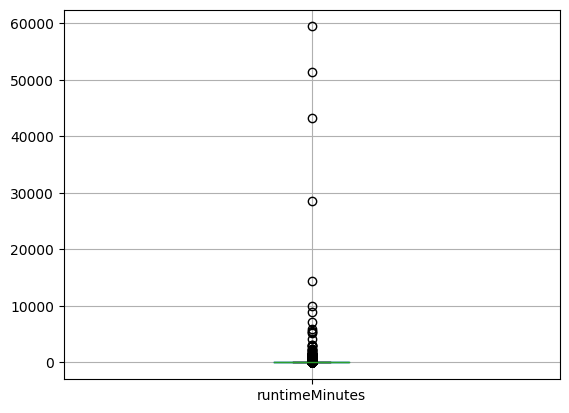

In [27]:
%matplotlib inline
# title_basics_processed.info()
title_basics_processed.boxplot(column='runtimeMinutes', return_type='axes');

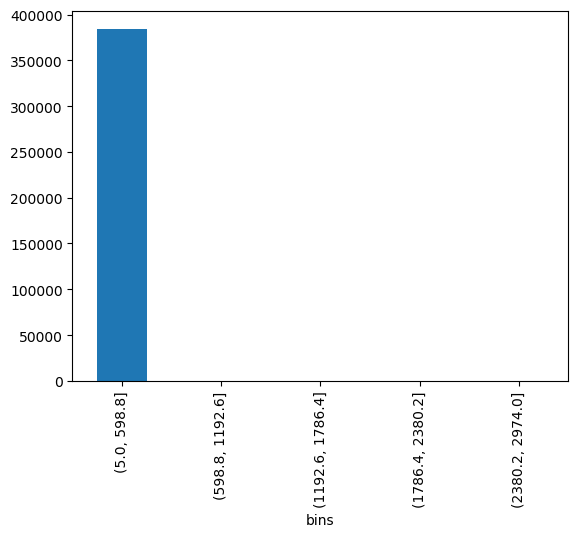

In [28]:
import matplotlib.pyplot as plt

# create a sample dataframe
title_basics_processed_visual = title_basics_processed

# create an array of bin edges
bin_edges = np.linspace(5, 2974, num=6)

# create bins and assign to a new column
title_basics_processed_visual['bins'] = pd.cut(title_basics_processed_visual['runtimeMinutes'], bin_edges)

# use groupby and plot
title_basics_processed_visual.groupby('bins').size().plot(kind='bar')
plt.show()


In [29]:
#So it seems like most of the runtimeMinutes is within 600 mins
#so lets get the unecessarey values out of the data set
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes <= 600]
#remove movies with duration more than 10 hours
max_elements = title_basics_processed.max()
print(max_elements)
title_basics_processed.nunique(axis=0)
title_basics_processed.head()

tconst                                                    tt9916754
primaryTitle      Šentilj-Spielfeld - Border Crossing That Once Was
originalTitle                             è solo questione di tempo
startYear                                                      2020
runtimeMinutes                                                  600
genres                                                           \N
bins                                                (598.8, 1192.6]
dtype: object


tconst                   primaryTitle                  originalTitle  \
8    tt0000009                     Miss Jerry                     Miss Jerry   
144  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
498  tt0000502                       Bohemios                       Bohemios   
570  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
587  tt0000591               The Prodigal Son              L'enfant prodigue   

     startYear  runtimeMinutes                      genres          bins  
8         1938              45                     Romance  (5.0, 598.8]  
144       1938             100      Documentary,News,Sport  (5.0, 598.8]  
498       1938             100                          \N  (5.0, 598.8]  
570       1938              70  Action,Adventure,Biography  (5.0, 598.8]  
587       1938              90                       Drama  (5.0, 598.8]

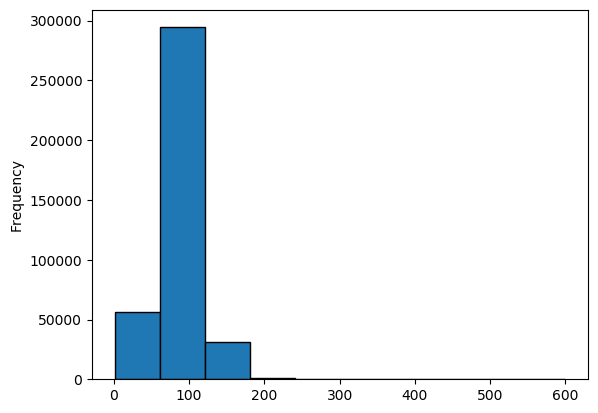

In [30]:
%matplotlib inline

title_basics_processed['runtimeMinutes'].plot(kind='hist', edgecolor='black')

In [31]:
### transform genre CSV type feature to one-hot-encoding like columns for ML usage

title_basics_processed = title_basics_processed[title_basics_processed.genres != '\\N']

genre_split = list(title_basics_processed.genres)
genre_split = ','.join(genre_split)
genre_split = genre_split.split(',')
genre_split = list(set(genre_split))
for k in genre_split:
    title_basics_processed[k] = 0
    
for k in title_basics_processed.index:
    x = title_basics_processed['genres'][k].split(',')
    for j in x:
        title_basics_processed[j][k] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [32]:
title_basics_processed.head()

tconst                    primaryTitle  \
8    tt0000009                      Miss Jerry   
144  tt0000147   The Corbett-Fitzsimmons Fight   
570  tt0000574     The Story of the Kelly Gang   
587  tt0000591                The Prodigal Son   
672  tt0000679  The Fairylogue and Radio-Plays   

                      originalTitle  startYear  runtimeMinutes  \
8                        Miss Jerry       1938              45   
144   The Corbett-Fitzsimmons Fight       1938             100   
570     The Story of the Kelly Gang       1938              70   
587               L'enfant prodigue       1938              90   
672  The Fairylogue and Radio-Plays       1938             120   

                         genres          bins  Thriller  Reality-TV  Short  \
8                       Romance  (5.0, 598.8]         0           0      0   
144      Documentary,News,Sport  (5.0, 598.8]         0           0      0   
570  Action,Adventure,Biography  (5.0, 598.8]         0           0      0   
587                       Drama  (5.0, 598.8]         0           0      0   
672           Adventure,Fantasy  (5.0, 598.8]         0           0      0   

     ...  Mystery  Action  Comedy  Sci-Fi  Crime  Romance  Fantasy  Western  \
8    ...        0       0       0       0      0        1        0        0   
144  ...        0       0       0       0      0        0        0        0   
570  ...        0       1       0       0      0        0        0        0   
587  ...        0       0       0       0      0        0        0        0   
672  ...        0       0       0       0      0        0        1        0   

     Drama  Family  
8        0       0  
144      0       0  
570      0       0  
587      1       0  
672      0       0  

[5 rows x 35 columns]

In [33]:
title_basics_processed = title_basics_processed.drop(columns = ["bins","genres"] )
title_basics_processed.head()

tconst                    primaryTitle  \
8    tt0000009                      Miss Jerry   
144  tt0000147   The Corbett-Fitzsimmons Fight   
570  tt0000574     The Story of the Kelly Gang   
587  tt0000591                The Prodigal Son   
672  tt0000679  The Fairylogue and Radio-Plays   

                      originalTitle  startYear  runtimeMinutes  Thriller  \
8                        Miss Jerry       1938              45         0   
144   The Corbett-Fitzsimmons Fight       1938             100         0   
570     The Story of the Kelly Gang       1938              70         0   
587               L'enfant prodigue       1938              90         0   
672  The Fairylogue and Radio-Plays       1938             120         0   

     Reality-TV  Short  Adult  Music  ...  Mystery  Action  Comedy  Sci-Fi  \
8             0      0      0      0  ...        0       0       0       0   
144           0      0      0      0  ...        0       0       0       0   
570           0      0      0      0  ...        0       1       0       0   
587           0      0      0      0  ...        0       0       0       0   
672           0      0      0      0  ...        0       0       0       0   

     Crime  Romance  Fantasy  Western  Drama  Family  
8        0        1        0        0      0       0  
144      0        0        0        0      0       0  
570      0        0        0        0      0       0  
587      0        0        0        0      1       0  
672      0        0        1        0      0       0  

[5 rows x 33 columns]

In [34]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360762 entries, 8 to 9469897
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          360762 non-null  object
 1   primaryTitle    360762 non-null  object
 2   originalTitle   360762 non-null  object
 3   startYear       360762 non-null  int64 
 4   runtimeMinutes  360762 non-null  int64 
 5   Thriller        360762 non-null  int64 
 6   Reality-TV      360762 non-null  int64 
 7   Short           360762 non-null  int64 
 8   Adult           360762 non-null  int64 
 9   Music           360762 non-null  int64 
 10  Documentary     360762 non-null  int64 
 11  Film-Noir       360762 non-null  int64 
 12  Talk-Show       360762 non-null  int64 
 13  War             360762 non-null  int64 
 14  Game-Show       360762 non-null  int64 
 15  History         360762 non-null  int64 
 16  Animation       360762 non-null  int64 
 17  Biography       360762 non-n

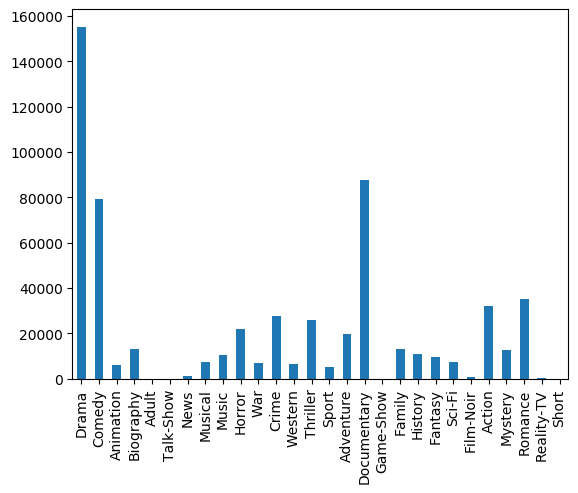

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt


title_basics_processed[['Drama','Comedy','Animation','Biography',
                        'Adult','Talk-Show','News','Musical','Music',
                       'Horror','War','Crime','Western','Thriller','Sport',
                        'Adventure','Documentary','Game-Show','Family','History',
                       'Fantasy','Sci-Fi','Film-Noir','Action','Mystery','Romance','Reality-TV','Short']].sum().plot.bar()

plt.show()

In [36]:
title_basics_processed = title_basics_processed.sort_index()
title_basics_processed

tconst                                       primaryTitle  \
8        tt0000009                                         Miss Jerry   
144      tt0000147                      The Corbett-Fitzsimmons Fight   
570      tt0000574                        The Story of the Kelly Gang   
587      tt0000591                                   The Prodigal Son   
672      tt0000679                     The Fairylogue and Radio-Plays   
...            ...                                                ...   
9469712  tt9916362                                              Coven   
9469796  tt9916538                                Kuambil Lagi Hatiku   
9469837  tt9916622        Rodolpho Teóphilo - O Legado de um Pioneiro   
9469864  tt9916680  De la ilusión al desconcierto: cine colombiano...   
9469897  tt9916754                     Chico Albuquerque - Revelações   

                                             originalTitle  startYear  \
8                                               Miss Jerry       1938   
144                          The Corbett-Fitzsimmons Fight       1938   
570                            The Story of the Kelly Gang       1938   
587                                      L'enfant prodigue       1938   
672                         The Fairylogue and Radio-Plays       1938   
...                                                    ...        ...   
9469712                                           Akelarre       2020   
9469796                                Kuambil Lagi Hatiku       2019   
9469837        Rodolpho Teóphilo - O Legado de um Pioneiro       2015   
9469864  De la ilusión al desconcierto: cine colombiano...       2007   
9469897                     Chico Albuquerque - Revelações       2013   

         runtimeMinutes  Thriller  Reality-TV  Short  Adult  Music  ...  \
8                    45         0           0      0      0      0  ...   
144                 100         0           0      0      0      0  ...   
570                  70         0           0      0      0      0  ...   
587                  90         0           0      0      0      0  ...   
672                 120         0           0      0      0      0  ...   
...                 ...       ...         ...    ...    ...    ...  ...   
9469712              92         0           0      0      0      0  ...   
9469796             123         0           0      0      0      0  ...   
9469837              57         0           0      0      0      0  ...   
9469864             100         0           0      0      0      0  ...   
9469897              49         0           0      0      0      0  ...   

         Mystery  Action  Comedy  Sci-Fi  Crime  Romance  Fantasy  Western  \
8              0       0       0       0      0        1        0        0   
144            0       0       0       0      0        0        0        0   
570            0       1       0       0      0        0        0        0   
587            0       0       0       0      0        0        0        0   
672            0       0       0       0      0        0        1        0   
...          ...     ...     ...     ...    ...      ...      ...      ...   
9469712        0       0       0       0      0        0        0        0   
9469796        0       0       0       0      0        0        0        0   
9469837        0       0       0       0      0        0        0        0   
9469864        0       0       0       0      0        0        0        0   
9469897        0       0       0       0      0        0        0        0   

         Drama  Family  
8            0       0  
144          0       0  
570          0       0  
587          1       0  
672          0       0  
...        ...     ...  
9469712      1       0  
9469796      1       0  
9469837      0       0  
9469864      0       0  
9469897      0       0  

[360762 rows x 33 columns]

In [37]:
title_basics_processed = title_basics_processed.drop(columns= ['Short','Reality-TV'])
title_basics_processed = title_basics_processed.drop(columns= ['Game-Show','Talk-Show','Adult'])
# title_basics_processed = title_basics_processed.drop(columns= ['index']) #no puprpose of this index , but in my case I didnt have this column, in case its there uncomment and run this
title_basics_processed.head()

tconst                    primaryTitle  \
8    tt0000009                      Miss Jerry   
144  tt0000147   The Corbett-Fitzsimmons Fight   
570  tt0000574     The Story of the Kelly Gang   
587  tt0000591                The Prodigal Son   
672  tt0000679  The Fairylogue and Radio-Plays   

                      originalTitle  startYear  runtimeMinutes  Thriller  \
8                        Miss Jerry       1938              45         0   
144   The Corbett-Fitzsimmons Fight       1938             100         0   
570     The Story of the Kelly Gang       1938              70         0   
587               L'enfant prodigue       1938              90         0   
672  The Fairylogue and Radio-Plays       1938             120         0   

     Music  Documentary  Film-Noir  War  ...  Mystery  Action  Comedy  Sci-Fi  \
8        0            0          0    0  ...        0       0       0       0   
144      0            1          0    0  ...        0       0       0       0   
570      0            0          0    0  ...        0       1       0       0   
587      0            0          0    0  ...        0       0       0       0   
672      0            0          0    0  ...        0       0       0       0   

     Crime  Romance  Fantasy  Western  Drama  Family  
8        0        1        0        0      0       0  
144      0        0        0        0      0       0  
570      0        0        0        0      0       0  
587      0        0        0        0      1       0  
672      0        0        1        0      0       0  

[5 rows x 28 columns]

In [38]:
title_basics_processed = title_basics_processed.dropna()
title_basics_processed.nunique(axis=0)
title_basics_processed.shape

(360762, 28)

In [39]:
# We will see how to merge the attributes of the 2 data sets to have a holistic data 
# set that we will be using going forward
# this data set has ratings and votes
title_ratings ='csv_files/title.ratings.tsv'
obj = s3.get_object(Bucket = bucket_name,Key = title_ratings)
df_title_ratings = pd.read_table(obj['Body'])
df_title_ratings.dropna()
df_title_ratings.head()

tconst  averageRating  numVotes
0  tt0000001            5.7      1930
1  tt0000002            5.8       261
2  tt0000003            6.5      1745
3  tt0000004            5.6       176
4  tt0000005            6.2      2560

In [40]:
final = pd.merge(left=title_basics_processed, right=df_title_ratings, on='tconst')
final.shape

(246914, 30)

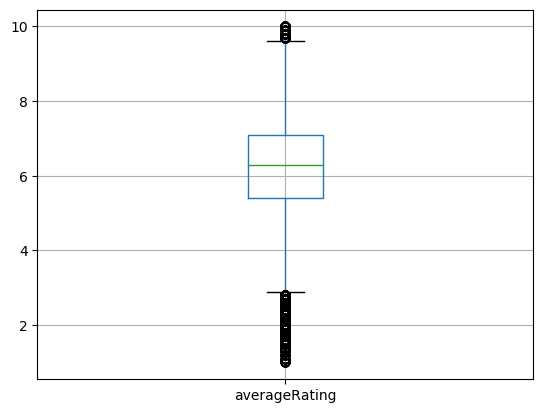

In [41]:
%matplotlib inline
final.boxplot(column='averageRating', return_type='axes');

In [42]:
final.describe()

startYear  runtimeMinutes       Thriller          Music  \
count  246914.000000   246914.000000  246914.000000  246914.000000   
mean     1994.895684       94.090477       0.088816       0.028990   
std        24.842108       24.504975       0.284479       0.167778   
min      1938.000000        1.000000       0.000000       0.000000   
25%      1978.000000       81.000000       0.000000       0.000000   
50%      2005.000000       91.000000       0.000000       0.000000   
75%      2015.000000      103.000000       0.000000       0.000000   
max      2020.000000      580.000000       1.000000       1.000000   

         Documentary      Film-Noir            War        History  \
count  246914.000000  246914.000000  246914.000000  246914.000000   
mean        0.162081       0.003580       0.022891       0.030278   
std         0.368526       0.059728       0.149555       0.171351   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

           Animation      Biography  ...         Comedy         Sci-Fi  \
count  246914.000000  246914.000000  ...  246914.000000  246914.000000   
mean        0.018541       0.034133  ...       0.261626       0.025470   
std         0.134897       0.181572  ...       0.439521       0.157549   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       1.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

               Crime        Romance        Fantasy        Western  \
count  246914.000000  246914.000000  246914.000000  246914.000000   
mean        0.093450       0.118215       0.031582       0.019736   
std         0.291062       0.322863       0.174884       0.139091   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

               Drama         Family  averageRating      numVotes  
count  246914.000000  246914.000000  246914.000000  2.469140e+05  
mean        0.471561       0.041087       6.183915  4.101846e+03  
std         0.499192       0.198492       1.333490  3.721378e+04  
min         0.000000       0.000000       1.000000  5.000000e+00  
25%         0.000000       0.000000       5.400000  2.300000e+01  
50%         0.000000       0.000000       6.300000  8.100000e+01  
75%         1.000000       0.000000       7.100000  4.060000e+02  
max         1.000000       1.000000      10.000000  2.673885e+06  

[8 rows x 27 columns]

In [43]:
# Makes sense to trim down numvotes >=5 ?
final = final[final.averageRating >= 5]
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205199 entries, 0 to 246913
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          205199 non-null  object 
 1   primaryTitle    205199 non-null  object 
 2   originalTitle   205199 non-null  object 
 3   startYear       205199 non-null  int64  
 4   runtimeMinutes  205199 non-null  int64  
 5   Thriller        205199 non-null  int64  
 6   Music           205199 non-null  int64  
 7   Documentary     205199 non-null  int64  
 8   Film-Noir       205199 non-null  int64  
 9   War             205199 non-null  int64  
 10  History         205199 non-null  int64  
 11  Animation       205199 non-null  int64  
 12  Biography       205199 non-null  int64  
 13  Horror          205199 non-null  int64  
 14  Adventure       205199 non-null  int64  
 15  Sport           205199 non-null  int64  
 16  News            205199 non-null  int64  
 17  Musical   

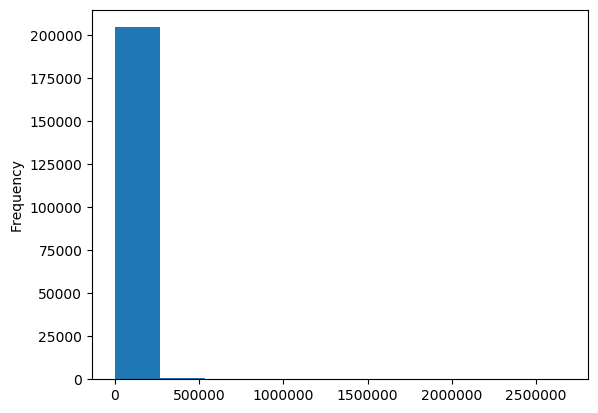

In [44]:
%matplotlib inline
final['numVotes'].plot(kind='hist')

In [45]:

final.dropna()
min_value = final['numVotes'].min()
max_value = final['numVotes'].max()
print(min_value)
print(max_value)

# print(final.info) #205199 rows

5
2673885


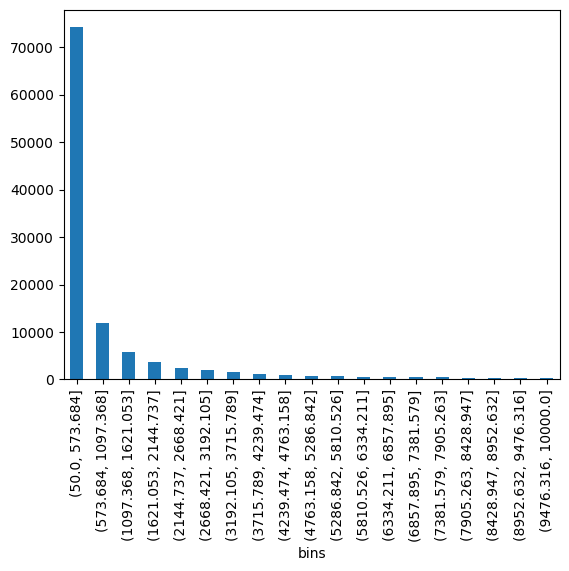

In [46]:
import matplotlib.pyplot as plt

# create a sample dataframe
final_visual = final

# create an array of bin edges
# 2673885,297102,33015,3672
bin_edges = np.linspace(50, 10000, num=20)

# create bins and assign to a new column
final_visual['bins'] = pd.cut(final_visual['numVotes'], bin_edges)

# use groupby and plot
final_visual.groupby('bins').size().plot(kind='bar')
plt.show()

In [47]:
final = final[(final.numVotes >= 50) ]
final = final[(final.numVotes <= 10000) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109586 entries, 0 to 246912
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   tconst          109586 non-null  object  
 1   primaryTitle    109586 non-null  object  
 2   originalTitle   109586 non-null  object  
 3   startYear       109586 non-null  int64   
 4   runtimeMinutes  109586 non-null  int64   
 5   Thriller        109586 non-null  int64   
 6   Music           109586 non-null  int64   
 7   Documentary     109586 non-null  int64   
 8   Film-Noir       109586 non-null  int64   
 9   War             109586 non-null  int64   
 10  History         109586 non-null  int64   
 11  Animation       109586 non-null  int64   
 12  Biography       109586 non-null  int64   
 13  Horror          109586 non-null  int64   
 14  Adventure       109586 non-null  int64   
 15  Sport           109586 non-null  int64   
 16  News            109586 non-null  int64

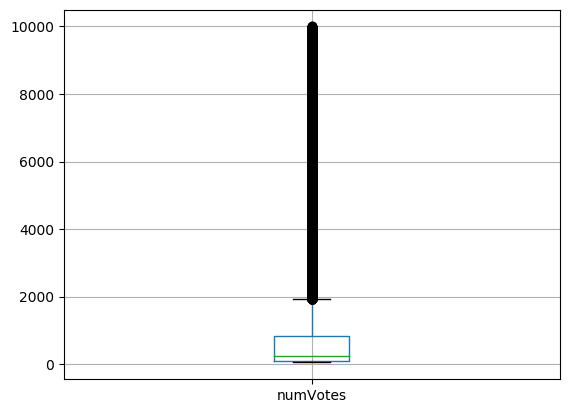

In [48]:
%matplotlib inline

final.boxplot(column='numVotes', return_type='axes');

In [49]:
final = final[(final.numVotes >= 50) ]
final = final[(final.numVotes <= 2000) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95489 entries, 0 to 246911
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          95489 non-null  object  
 1   primaryTitle    95489 non-null  object  
 2   originalTitle   95489 non-null  object  
 3   startYear       95489 non-null  int64   
 4   runtimeMinutes  95489 non-null  int64   
 5   Thriller        95489 non-null  int64   
 6   Music           95489 non-null  int64   
 7   Documentary     95489 non-null  int64   
 8   Film-Noir       95489 non-null  int64   
 9   War             95489 non-null  int64   
 10  History         95489 non-null  int64   
 11  Animation       95489 non-null  int64   
 12  Biography       95489 non-null  int64   
 13  Horror          95489 non-null  int64   
 14  Adventure       95489 non-null  int64   
 15  Sport           95489 non-null  int64   
 16  News            95489 non-null  int64   
 17  Musical    

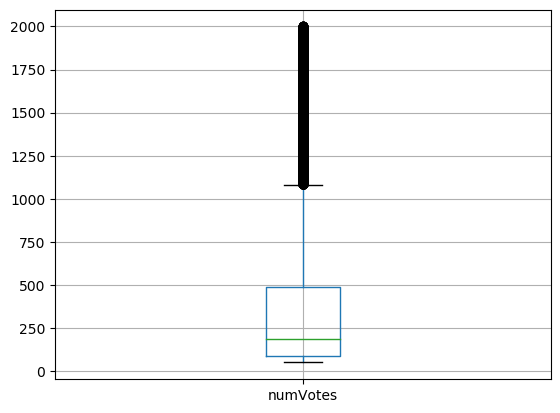

In [50]:
%matplotlib inline

final.boxplot(column='numVotes', return_type='axes');

In [51]:
final = final[(final.numVotes >= 50) ]
final = final[(final.numVotes <= 400) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67219 entries, 0 to 246908
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          67219 non-null  object  
 1   primaryTitle    67219 non-null  object  
 2   originalTitle   67219 non-null  object  
 3   startYear       67219 non-null  int64   
 4   runtimeMinutes  67219 non-null  int64   
 5   Thriller        67219 non-null  int64   
 6   Music           67219 non-null  int64   
 7   Documentary     67219 non-null  int64   
 8   Film-Noir       67219 non-null  int64   
 9   War             67219 non-null  int64   
 10  History         67219 non-null  int64   
 11  Animation       67219 non-null  int64   
 12  Biography       67219 non-null  int64   
 13  Horror          67219 non-null  int64   
 14  Adventure       67219 non-null  int64   
 15  Sport           67219 non-null  int64   
 16  News            67219 non-null  int64   
 17  Musical    

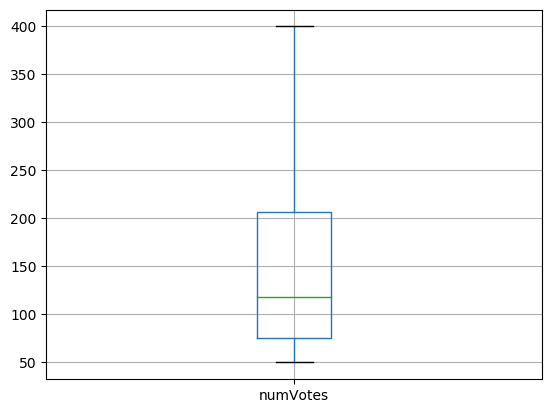

In [52]:
%matplotlib inline
final.boxplot(column='numVotes', return_type='axes');

In [53]:
#shuffle 
final = final.sample(frac=1, random_state=42)

In [54]:
final.head()

tconst          primaryTitle         originalTitle  startYear  \
107957  tt0398212  After the Day Before                Másnap       2004   
58927   tt0114574     The Suburbanators     The Suburbanators       1995   
77263   tt0193706  Afraid of Everything  Afraid of Everything       1999   
200045  tt3645074          The Gold Bug  El escarabajo de oro       2014   
24949   tt0054271      Holiday in Spain      Scent of Mystery       1960   

        runtimeMinutes  Thriller  Music  Documentary  Film-Noir  War  ...  \
107957             120         0      0            0          0    0  ...   
58927               87         0      0            0          0    0  ...   
77263               80         0      0            0          0    0  ...   
200045             100         0      0            0          0    0  ...   
24949              125         0      0            0          0    0  ...   

        Sci-Fi  Crime  Romance  Fantasy  Western  Drama  Family  \
107957       0      1        0        0        0      1       0   
58927        0      0        0        0        0      0       0   
77263        0      0        0        0        0      1       0   
200045       0      0        0        0        0      1       0   
24949        0      1        0        0        0      0       0   

        averageRating  numVotes             bins  
107957            6.9       333  (50.0, 573.684]  
58927             7.0        69  (50.0, 573.684]  
77263             7.0        77  (50.0, 573.684]  
200045            6.4       175  (50.0, 573.684]  
24949             5.5       378  (50.0, 573.684]  

[5 rows x 31 columns]

In [55]:
final = final.sort_index()
final = final.reset_index()

In [56]:
final=final.drop(['index'], axis = 1)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67219 entries, 0 to 67218
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          67219 non-null  object  
 1   primaryTitle    67219 non-null  object  
 2   originalTitle   67219 non-null  object  
 3   startYear       67219 non-null  int64   
 4   runtimeMinutes  67219 non-null  int64   
 5   Thriller        67219 non-null  int64   
 6   Music           67219 non-null  int64   
 7   Documentary     67219 non-null  int64   
 8   Film-Noir       67219 non-null  int64   
 9   War             67219 non-null  int64   
 10  History         67219 non-null  int64   
 11  Animation       67219 non-null  int64   
 12  Biography       67219 non-null  int64   
 13  Horror          67219 non-null  int64   
 14  Adventure       67219 non-null  int64   
 15  Sport           67219 non-null  int64   
 16  News            67219 non-null  int64   
 17  Musical     

In [57]:
#Columns to be saved for later use , since some columns are not needed for tarining the recommendation algorithm
movie_data = final[['tconst','primaryTitle','originalTitle']].copy()
final=final.drop(['tconst','primaryTitle','originalTitle'], axis = 1)

In [58]:
final = final.drop(['bins'],axis = 1)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67219 entries, 0 to 67218
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       67219 non-null  int64  
 1   runtimeMinutes  67219 non-null  int64  
 2   Thriller        67219 non-null  int64  
 3   Music           67219 non-null  int64  
 4   Documentary     67219 non-null  int64  
 5   Film-Noir       67219 non-null  int64  
 6   War             67219 non-null  int64  
 7   History         67219 non-null  int64  
 8   Animation       67219 non-null  int64  
 9   Biography       67219 non-null  int64  
 10  Horror          67219 non-null  int64  
 11  Adventure       67219 non-null  int64  
 12  Sport           67219 non-null  int64  
 13  News            67219 non-null  int64  
 14  Musical         67219 non-null  int64  
 15  Mystery         67219 non-null  int64  
 16  Action          67219 non-null  int64  
 17  Comedy          67219 non-null 

In [59]:
pip show joblib

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: 
Required-by: nltk, scikit-learn
Note: you may need to restart the kernel to use updated packages.


In [60]:
# Scaling of the final dataset
# We will be saving this model for use later on in real time predictions

from sklearn.preprocessing import StandardScaler
import joblib as joblib

# create a scaler object
column_list = list(final.columns)
print(column_list)

scaler = StandardScaler()
scaler.fit(final)
joblib.dump(scaler, 'model.joblib')


df_final_standardized = scaler.transform(final).astype(np.float32) 
#When we create the sagemaker pipeline , this should be automatically handled for us

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'News', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


In [61]:
# This is where we will everything
bucket_name='awswomeninengineering2023-477713232171'

In [62]:
#upload the standard scalar model to the s3 bucket
session = boto3.Session()
s3 = session.client('s3')
role = get_execution_role()
scaler_key = 'model.joblib'
s3.upload_file('model.joblib', bucket_name, scaler_key)

In [63]:
#just testing purpose
from pandas.io.json import json_normalize
import json
import joblib
model_trial = joblib.load("model.joblib")

print(column_list)
# JSON key/value features
# json_string = '{"startYear":[2010], "runtimeMinutes":[150], "Documentary":[0], "News":[0],"Action":[0],"Musical":[0],"Adventure":[0], "Sci-Fi":[1],"History":[0],"Mystery":[0],"Horror":[1], "Fantasy":[0],"War":[0], "Romance":[0], "Music":[0], "Biography":[0], "Sport":[0],"Drama":[1],"Western":[0], "Film-Noir": [0],"Comedy":[0], "Family":[1],"Crime":[1],"Animation":[0],"Thriller":[0],"averageRating":[5.3],"numVotes": [8000]}'


json_string = '{"startYear":[2010], "runtimeMinutes":[150], "Family":[0], "Horror":[0], "Film-Noir":[0], "Animation":[0], "Thriller":[0], "War":[0], "Sport":[0], "Musical":[0], "Action":[0], "History":[0], "Romance":[0], "Comedy":[0], "News":[0], "Documentary":[0], "Music":[0], "Drama":[0], "Western":[0], "Sci-Fi":[0], "Fantasy":[0], "Biography":[0], "Adventure":[0], "Crime":[0], "Mystery":[0], "averageRating":[0], "numVotes":[0]}'

# Convert the json string to a python dictionary
json_dict = json.loads(json_string)

# Normalize the json_dict to create a dataframe
json_dict_df = pd.DataFrame(json_dict)

# json_dict_df_from_model = scaler.transform(json_dict_df).astype('float32')
json_dict_df_from_model = model_trial.transform(json_dict_df).astype('float32')
json_dict_df_from_model #this is numpy array

# convert numpy array to list
json_dict_df_from_model = json_dict_df_from_model.tolist()

# convert list to json
json_response = json.dumps(json_dict_df_from_model)
respJSON = {'Output': json_response}
respJSON

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'News', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


{'Output': '[[0.694806694984436, 2.2639517784118652, -0.2686876654624939, -0.18072344362735748, -0.4244655668735504, -0.06362324953079224, -0.16373340785503387, -0.1832536906003952, -0.1356191188097, -0.18308018147945404, -0.19453215599060059, -0.24885399639606476, -0.11792843043804169, -0.049755942076444626, -0.1617104709148407, -0.19275420904159546, -0.30500397086143494, -0.5977928638458252, -0.12182311713695526, -0.3171144723892212, -0.38422682881355286, -0.16999703645706177, -0.16696204245090485, -1.037368893623352, -0.21805289387702942, -7.467110633850098, -1.621128797531128]]'}

In [64]:
df_final_standardized = pd.DataFrame(df_final_standardized)
df_final_standardized.columns = column_list
df_final_standardized.head()

startYear  runtimeMinutes  Thriller     Music  Documentary  Film-Noir  \
0  -2.051811       -2.038425 -0.268688 -0.180723    -0.424466  -0.063623   
1  -2.051811        1.034701 -0.268688 -0.180723    -0.424466  -0.063623   
2  -2.051811       -1.833550 -0.268688 -0.180723    -0.424466  -0.063623   
3  -2.051811       -1.710625 -0.268688 -0.180723    -0.424466  -0.063623   
4  -2.051811       -1.915501 -0.268688 -0.180723    -0.424466  -0.063623   

        War   History  Animation  Biography  ...    Comedy    Sci-Fi  \
0 -0.163733 -0.183254  -0.135619  -0.183080  ... -0.597793 -0.121823   
1 -0.163733 -0.183254  -0.135619  -0.183080  ... -0.597793 -0.121823   
2 -0.163733 -0.183254  -0.135619   5.462088  ... -0.597793 -0.121823   
3 -0.163733 -0.183254  -0.135619  -0.183080  ... -0.597793 -0.121823   
4 -0.163733 -0.183254  -0.135619  -0.183080  ... -0.597793 -0.121823   

      Crime   Romance   Fantasy   Western     Drama    Family  averageRating  \
0 -0.317114  2.602629 -0.169997 -0.166962 -1.037369 -0.218053      -1.306433   
1 -0.317114 -0.384227  5.882456 -0.166962 -1.037369 -0.218053      -1.422672   
2 -0.317114 -0.384227 -0.169997 -0.166962  0.963977  4.586043      -1.073954   
3 -0.317114 -0.384227 -0.169997 -0.166962  0.963977 -0.218053      -0.608997   
4 -0.317114 -0.384227 -0.169997 -0.166962  0.963977 -0.218053      -0.492758   

   numVotes  
0  0.544271  
1 -0.910102  
2 -0.996287  
3  0.985970  
4 -0.694639  

[5 rows x 27 columns]

In [65]:
# this will train on the data set that we have , to find clusters
# this will take time , so for the workshop we will need to distribute it via s3 bucket and a presigned url ?
# from time import gmtime, strftime
# from sagemaker import KMeans
# output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# output_folder = 'KMeans-results-v2-' + output_time
# K = range(2, 51) # change the range to be used for k
# job_names = []

# # launching jobs for all k
# for k in K:
#     print('starting train job for cluster with k:' + str(k))
#     output_location = 's3://{}/kmeans_movieoutput/'.format(bucket_name) + output_folder
#     print('training artifacts will be uploaded to: {}'.format(output_location))
#     job_name = 'movierecommender-AWEsome-' + str(k)
    
#     kmeans = KMeans(role=role, instance_count=1, instance_type='ml.c4.xlarge', init_method='kmeans++', 
#                 output_path=output_location, k=k, epochs=5) 
#     kmeans.fit(kmeans.record_set(df_final_standardized.values), job_name=job_name)
    
#     job_names.append(job_name)
#     print('end of train job for cluster: ' + str(k))

In [66]:
!pip install mxnet
print(bucket_name)


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
awswomeninengineering2023-477713232171


kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-2/output/model.tar.gz
Model for k=2 (kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-2/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-3/output/model.tar.gz
Model for k=3 (kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-3/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-4/output/model.tar.gz
Model for k=4 (kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-4/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-5/output/model.tar.gz
Model for k=5 (kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-31-29/movierecommender-AWEsome-5/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-11-22-3

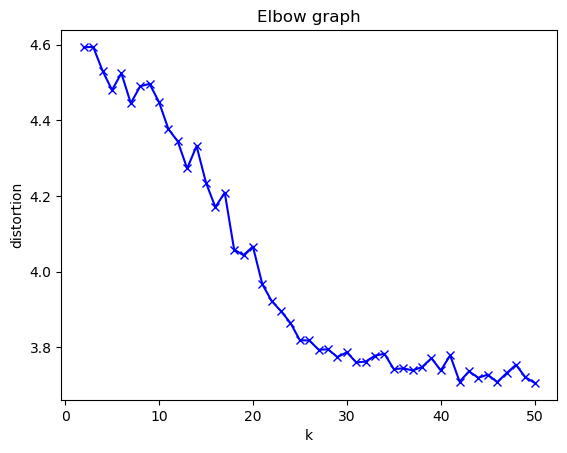

In [68]:
#use already trained models in s3 to find what is the appropriate number of clusters
#need to use a different way to find the elbow graph of a sagemaker trained kmeans model as opposed to
#sklearn k means
import mxnet as mx
from scipy.spatial.distance import cdist
markers = ['o', 'v', 's']
models = {}
distortions = []
output_folder = 'kmeans_movieoutput/';
result_folder = 'KMeans-results-v2-2023-03-11-22-31-29/'
final_folder ='movierecommender-AWEsome-'
K = range(2, 51) # change the range to be used for k
for k in K:
    s3_client = boto3.client('s3')
    key = output_folder + result_folder + final_folder+str(k) +  '/output/model.tar.gz'
    print(key)
    s3_client.download_file(bucket_name, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(df_final_standardized.values, kmeans_numpy, 'euclidean'), axis=1)) / df_final_standardized.values.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

In [69]:
#above steps were done to find the optimal number of clusters.
#once that is known , I train the model for k=25 and then deploy the model
from sagemaker import KMeans
kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name + '/',
                init_method='kmeans++',
                k=25, 
                epochs=5)
kmeans.fit(kmeans.record_set(df_final_standardized.values))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2023-03-14-23-53-48-555


2023-03-14 23:53:48 Starting - Starting the training job...
2023-03-14 23:54:13 Starting - Preparing the instances for training......
2023-03-14 23:55:09 Downloading - Downloading input data...
2023-03-14 23:55:34 Training - Downloading the training image......
2023-03-14 23:56:49 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2023 23:56:58 INFO 140277924755264] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', 

In [70]:
#deploy a trained model
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2023-03-14-23-58-03-305
INFO:sagemaker:Creating endpoint-config with name kmeans-2023-03-14-23-58-03-305
INFO:sagemaker:Creating endpoint with name kmeans-2023-03-14-23-58-03-305


-------!

In [71]:
df_final_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67219 entries, 0 to 67218
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       67219 non-null  float32
 1   runtimeMinutes  67219 non-null  float32
 2   Thriller        67219 non-null  float32
 3   Music           67219 non-null  float32
 4   Documentary     67219 non-null  float32
 5   Film-Noir       67219 non-null  float32
 6   War             67219 non-null  float32
 7   History         67219 non-null  float32
 8   Animation       67219 non-null  float32
 9   Biography       67219 non-null  float32
 10  Horror          67219 non-null  float32
 11  Adventure       67219 non-null  float32
 12  Sport           67219 non-null  float32
 13  News            67219 non-null  float32
 14  Musical         67219 non-null  float32
 15  Mystery         67219 non-null  float32
 16  Action          67219 non-null  float32
 17  Comedy          67219 non-null 

In [72]:
train_data1 = df_final_standardized[0:40000]
train_data2 = df_final_standardized[40000:67219]
# train_data3 = df_final_standardized[80000:91815]


result1=kmeans_predictor.predict(train_data1.values)
result2=kmeans_predictor.predict(train_data2.values)
# result3=kmeans_predictor.predict(train_data3.values)

result = result1 + result2 

In [73]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
predictions = pd.DataFrame(data=cluster_labels)

In [74]:
predictions.info

<bound method DataFrame.info of           0
0      24.0
1      14.0
2       7.0
3       5.0
4       5.0
...     ...
67214  18.0
67215   2.0
67216   1.0
67217   2.0
67218   2.0

[67219 rows x 1 columns]>

In [75]:
column_list

['startYear',
 'runtimeMinutes',
 'Thriller',
 'Music',
 'Documentary',
 'Film-Noir',
 'War',
 'History',
 'Animation',
 'Biography',
 'Horror',
 'Adventure',
 'Sport',
 'News',
 'Musical',
 'Mystery',
 'Action',
 'Comedy',
 'Sci-Fi',
 'Crime',
 'Romance',
 'Fantasy',
 'Western',
 'Drama',
 'Family',
 'averageRating',
 'numVotes']

In [76]:
#this pred_final data needs to be saved so that it can be used for lookup during real time predictions
pred_info = pd.concat([predictions, final], axis=1)
pred_info = pred_info.rename(columns={0: 'cluster'})
pred_final = pd.concat([movie_data, pred_info], axis=1)
pred_final

tconst                    primaryTitle  \
0      tt0000009                      Miss Jerry   
1      tt0000679  The Fairylogue and Radio-Plays   
2      tt0001285               The Life of Moses   
3      tt0001892                  Den sorte drøm   
4      tt0001964                   The Traitress   
...          ...                             ...   
67214  tt9914286               Sokagin Çocuklari   
67215  tt9914644    9/11: Escape from the Towers   
67216  tt9914942          Life Without Sara Amat   
67217  tt9914972                  Blind Ambition   
67218  tt9916160                      Drømmeland   

                        originalTitle  cluster  startYear  runtimeMinutes  \
0                          Miss Jerry     24.0       1938              45   
1      The Fairylogue and Radio-Plays     14.0       1938             120   
2                   The Life of Moses      7.0       1938              50   
3                      Den sorte drøm      5.0       1938              53   
4                      Die Verräterin      5.0       1938              48   
...                               ...      ...        ...             ...   
67214               Sokagin Çocuklari     18.0       2019              98   
67215    9/11: Escape from the Towers      2.0       2018             120   
67216      La vida sense la Sara Amat      1.0       2019              74   
67217                  Blind Ambition      2.0       2020              96   
67218                      Drømmeland      2.0       2019              72   

       Thriller  Music  Documentary  Film-Noir  ...  Comedy  Sci-Fi  Crime  \
0             0      0            0          0  ...       0       0      0   
1             0      0            0          0  ...       0       0      0   
2             0      0            0          0  ...       0       0      0   
3             0      0            0          0  ...       0       0      0   
4             0      0            0          0  ...       0       0      0   
...         ...    ...          ...        ...  ...     ...     ...    ...   
67214         0      0            0          0  ...       0       0      0   
67215         0      0            1          0  ...       0       0      0   
67216         0      0            0          0  ...       0       0      0   
67217         0      0            1          0  ...       0       0      0   
67218         0      0            1          0  ...       0       0      0   

       Romance  Fantasy  Western  Drama  Family  averageRating  numVotes  
0            1        0        0      0       0            5.3       201  
1            0        1        0      0       0            5.2        66  
2            0        0        0      1       1            5.5        58  
3            0        0        0      1       0            5.9       242  
4            0        0        0      1       0            6.0        86  
...        ...      ...      ...    ...     ...            ...       ...  
67214        0        0        0      1       1            5.1       217  
67215        0        0        0      0       0            8.3       107  
67216        0        0        0      1       0            6.7       164  
67217        0        0        0      0       0            7.2       200  
67218        0        0        0      0       0            6.3        50  

[67219 rows x 31 columns]

In [77]:
data_to_predict1 = {"startYear":[2015], "runtimeMinutes":[150], "Drama":[0], "Film-Noir":[0],"Fantasy":[0],"Animation":[0],
                    "Family":[0],"Documentary":[0],"War":[0],"Sport":[0],"Music":[0],"Western":[0],"Biography":[0],"Adventure":[1],
                    "News":[0],"History":[0],"Mystery":[0],"Sci-Fi":[1],"Action":[1],"Crime":[1],"Musical":[0],"Romance":[0],
                    "Comedy":[0],"Horror":[0],"Thriller":[1],"averageRating":[7],"numVotes":[50]}

in_data2 = pd.DataFrame(data_to_predict1)
input2 = scaler.transform(in_data2).astype('float32')
print(type(input2))
print(input2.ndim)
print(input2)
input2_pred = kmeans_predictor.predict(input2)
input2_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in input2_pred]
#predicted cluster 
print(int(input2_cluster[0]))

<class 'numpy.ndarray'>
2
[[ 0.88554406  2.2639518  -0.26868767 -0.18072344 -0.42446557 -0.06362325
  -0.16373341 -0.18325369 -0.13561912 -0.18308018 -0.19453216 -0.248854
  -0.11792843 20.098103   -0.16171047 -0.19275421 -0.30500397  1.6728202
   8.208623    3.1534355  -0.38422683 -0.16999704 -0.16696204 -1.0373689
   4.5860434   0.6696339  -1.0824721 ]]
4


In [78]:
recommendations = pred_final.loc[pred_final['cluster'] == 
            int(input2_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:10]
recommendations

tconst                                       primaryTitle  \
50536  tt21139706         Prince Oak Oakleyski and News Interviewers   
50499  tt21108248  Prince Oak Oakleyski Most Handsome in the Worl...   
52681   tt2448130                                 The Housing Bubble   
54637   tt3163908                                      Veil of Tears   
50921   tt2165723  Documentary: National March on Washington Agai...   
55359   tt3410666                PAY 2 PLAY: Democracy's High Stakes   
49842   tt2016259                                          Peace Out   
51323   tt2215777                                   Words of Witness   
52573   tt2418480                                            Furever   
47075   tt1638943                      What If Cannabis Cured Cancer   

                                           originalTitle  cluster  startYear  \
50536         Prince Oak Oakleyski and News Interviewers      4.0       2020   
50499  Prince Oak Oakleyski Most Handsome in the Worl...      4.0       2020   
52681                                 The Housing Bubble      4.0       2018   
54637                                      Veil of Tears      4.0       2014   
50921  Documentary: National March on Washington Agai...      4.0       2003   
55359                PAY 2 PLAY: Democracy's High Stakes      4.0       2014   
49842                                          Peace Out      4.0       2011   
51323                                   Words of Witness      4.0       2012   
52573                                            Furever      4.0       2013   
47075                      What If Cannabis Cured Cancer      4.0       2010   

       runtimeMinutes  Thriller  Music  Documentary  Film-Noir  ...  Comedy  \
50536              60         0      0            1          0  ...       0   
50499              60         0      0            1          0  ...       1   
52681              78         0      0            1          0  ...       0   
54637              90         0      0            1          0  ...       0   
50921              56         0      0            1          0  ...       0   
55359              87         0      0            1          0  ...       1   
49842              80         0      0            1          0  ...       0   
51323              70         0      0            1          0  ...       0   
52573              80         0      0            1          0  ...       0   
47075              60         0      0            1          0  ...       0   

       Sci-Fi  Crime  Romance  Fantasy  Western  Drama  Family  averageRating  \
50536       0      0        0        0        0      0       0            9.9   
50499       0      0        0        0        0      0       0            9.8   
52681       0      0        0        0        0      0       0            9.2   
54637       0      0        0        0        0      1       0            9.1   
50921       0      0        0        0        0      0       0            9.1   
55359       0      0        0        0        0      0       0            8.7   
49842       0      0        0        0        0      0       0            8.6   
51323       0      0        0        0        0      0       0            8.4   
52573       0      0        0        0        0      0       0            8.4   
47075       0      0        0        0        0      0       0            8.3   

       numVotes  
50536        59  
50499        57  
52681        51  
54637        68  
50921        58  
55359        64  
49842        59  
51323        69  
52573        62  
47075       241  

[10 rows x 31 columns]

In [79]:
#now do steps for using the sagemaker migration toolkit to convert the sckit-sklearn model for standardizing to 
#deploy to sagemaker 

import boto3
import json
import numpy as np

# Create a SageMaker runtime client
client = boto3.client('runtime.sagemaker')

# Define the endpoint name and the json structure to pass to it
endpoint_name = 'sm-endpoint-sklearn-2023-03-12-06-11-52'
json_structure = {"startYear":[2015], "runtimeMinutes":[150], "Drama":[0], "Film-Noir":[0],"Fantasy":[0],"Animation":[0],
                    "Family":[0],"Documentary":[0],"War":[0],"Sport":[0],"Music":[0],"Western":[0],"Biography":[0],"Adventure":[1],
                    "News":[0],"History":[0],"Mystery":[0],"Sci-Fi":[1],"Action":[1],"Crime":[1],"Musical":[0],"Romance":[0],
                    "Comedy":[1],"Horror":[0],"Thriller":[1],"averageRating":[7],"numVotes":[50]}


# Convert the json structure to a bytes object
payload = json.dumps(json_structure).encode('utf-8')

# Invoke the endpoint and get the response
response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=payload)

# Get the response body
response_body = response['Body'].read().decode('utf-8')

string_array = json.loads(response_body)["Output"]
np_array = np.fromstring(string_array.replace("[", "").replace("]", ""), sep=",")

arr_2d = np.reshape(np_array, (1, len(np_array)))

print(arr_2d.astype('float32'))
print(type(arr_2d))
print(arr_2d.ndim)

test_predictions = kmeans_predictor.predict(arr_2d.astype('float32'))
returned_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in test_predictions]
#predicted cluster 
print(int(returned_cluster[0]))

recommendations_sagemaker_models = pred_final.loc[pred_final['cluster'] == 
            int(returned_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:10]
recommendations_sagemaker_models


[[ 0.88554406  2.2639518  -1.0373689  -0.06362325 -0.16999704 -0.13561912
  -0.2180529  -0.42446557 -0.16373341 -0.11792843 -0.18072344 -0.16696204
  -0.18308018  4.0184207  -0.04975594 -0.18325369 -0.19275421  8.208623
   3.278646    3.1534355  -0.16171047 -0.38422683  1.6728202  -0.19453216
   3.7217934   0.6696339  -1.0824721 ]]
<class 'numpy.ndarray'>
2
3


tconst                        primaryTitle  \
33538   tt0389937                   Don: Plain & Tall   
37805   tt0972571                    Shut Up and Deal   
39581  tt10895784  Filthy Frank Final Full Lore Movie   
45135  tt14781302                        Cutting Shop   
47283   tt1665423                              S.O.L.   
28917   tt0262636            Naa Mogudu Nanke Sontham   
44646  tt14402302                   Accidental Family   
57683   tt4307176                         Pallati 176   
44560  tt14344488                         Pappur Biye   
42014   tt1251495                   Spicy Mac Project   

                            originalTitle  cluster  startYear  runtimeMinutes  \
33538                   Don: Plain & Tall      3.0       2003              78   
37805                    Shut Up and Deal      3.0       2007              85   
39581  Filthy Frank Final Full Lore Movie      3.0       2018             124   
45135                        Cutting Shop      3.0       2020             124   
47283                              S.O.L.      3.0       2011              80   
28917            Naa Mogudu Nanke Sontham      3.0       1989             147   
44646                   Accidental Family      3.0       2020              94   
57683                         Pallati 176      3.0       1986             115   
44560                         Pappur Biye      3.0       2020             136   
42014                   Spicy Mac Project      3.0       2009              90   

       Thriller  Music  Documentary  Film-Noir  ...  Comedy  Sci-Fi  Crime  \
33538         0      0            0          0  ...       1       0      0   
37805         0      0            0          0  ...       1       0      0   
39581         0      0            0          0  ...       1       0      0   
45135         0      0            0          0  ...       1       0      0   
47283         0      0            0          0  ...       1       0      0   
28917         0      0            0          0  ...       1       0      0   
44646         0      0            0          0  ...       1       0      0   
57683         0      0            0          0  ...       1       0      0   
44560         0      0            0          0  ...       1       0      0   
42014         0      0            0          0  ...       1       0      0   

       Romance  Fantasy  Western  Drama  Family  averageRating  numVotes  
33538        0        0        0      0       0           10.0       245  
37805        0        0        0      0       0           10.0       116  
39581        0        0        0      0       0            9.7       257  
45135        0        0        0      0       0            9.6       101  
47283        0        0        0      0       0            9.5       125  
28917        0        0        0      0       0            9.4       166  
44646        0        0        0      0       0            9.4        87  
57683        0        0        0      0       0            9.3       232  
44560        0        0        0      0       0            9.3       137  
42014        0        0        0      0       0            9.3       110  

[10 rows x 31 columns]

In [80]:
import boto3
import json
import io
import numpy as np

# Create a SageMaker runtime client
client = boto3.client('runtime.sagemaker')

# Define the endpoint name and the json structure to pass to it
endpoint_name = 'sm-endpoint-sklearn-2023-03-12-06-11-52'
json_structure = {"startYear":[2015], "runtimeMinutes":[150], "Drama":[0], "Film-Noir":[0],"Fantasy":[0],"Animation":[0],
                    "Family":[0],"Documentary":[0],"War":[0],"Sport":[0],"Music":[0],"Western":[0],"Biography":[0],"Adventure":[1],
                    "News":[0],"History":[0],"Mystery":[0],"Sci-Fi":[1],"Action":[1],"Crime":[1],"Musical":[0],"Romance":[0],
                    "Comedy":[1],"Horror":[0],"Thriller":[1],"averageRating":[7],"numVotes":[50]}


# Convert the json structure to a bytes object
payload = json.dumps(json_structure).encode('utf-8')

# Invoke the endpoint and get the response
response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=payload)

# Get the response body
response_body = response['Body'].read().decode('utf-8')

string_array = json.loads(response_body)["Output"]
np_array = np.fromstring(string_array.replace("[", "").replace("]", ""), sep=",")

arr_2d = np.reshape(np_array, (1, len(np_array)))

print(arr_2d.astype('float32'))
print(type(arr_2d))
print(arr_2d.ndim)

[[ 0.88554406  2.2639518  -1.0373689  -0.06362325 -0.16999704 -0.13561912
  -0.2180529  -0.42446557 -0.16373341 -0.11792843 -0.18072344 -0.16696204
  -0.18308018  4.0184207  -0.04975594 -0.18325369 -0.19275421  8.208623
   3.278646    3.1534355  -0.16171047 -0.38422683  1.6728202  -0.19453216
   3.7217934   0.6696339  -1.0824721 ]]
<class 'numpy.ndarray'>
2


In [81]:
# Simple function to create a csv from our numpy array
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=",", fmt="%g")
    return csv.getvalue().decode().rstrip()

In [82]:
import json

payload = np2csv(arr_2d.astype('float32'))

In [83]:
print(payload)

0.885544,2.26395,-1.03737,-0.0636232,-0.169997,-0.135619,-0.218053,-0.424466,-0.163733,-0.117928,-0.180723,-0.166962,-0.18308,4.01842,-0.0497559,-0.183254,-0.192754,8.20862,3.27865,3.15344,-0.16171,-0.384227,1.67282,-0.194532,3.72179,0.669634,-1.08247


In [126]:
response = client.invoke_endpoint(EndpointName="kmeans-2023-03-14-23-58-03-305", ContentType="text/csv", Body=payload)
result = json.loads(response["Body"].read().decode())
print(result)

# recommendations_cluster_prediction = pred_final.loc[pred_final['cluster'] == 
#             20].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:10]
# recommendations_cluster_prediction

{'predictions': [{'closest_cluster': 3.0, 'distance_to_cluster': 10.502318382263184}]}


In [85]:
!pip install awswrangler


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [127]:
#execution role is arn:aws:sts::477713232171:assumed-role/AmazonSageMaker-ExecutionRole-20221206T123014/SageMaker
import awswrangler as wr
wr.s3.to_parquet(
    df=pred_final,
    path="s3://awswomeninengineering2023-477713232171/clusteredfinaldata/",
    dataset=True,
    database="default",
    table="clusters"
);

In [128]:
col_names = ["tconst", "primarytitle", "originaltitle", "cluster", "startyear", "runtimeminutes", "thriller", "music",
            "documentary","film_noir","war","history","animation","biography","horror","adventure","sport","news","musical","mystery",
            "action","comedy","sci_fi","crime","romance","fantasy","western","drama","family","averagerating","numvotes"]


sql = """
SELECT
    *
FROM clusters
WHERE cluster =:x; order by averagerating , numvotes asc limit 10
"""

df = wr.athena.read_sql_query(sql, params={"x": result['predictions'][0]['closest_cluster']} , database="default")

In [129]:
df

tconst                                    primarytitle  \
0  tt6005118                      The Thing Before the Thing   
1  tt1381416  Tuck Bushman and the Legend of Piddledown Dale   
2  tt1381416  Tuck Bushman and the Legend of Piddledown Dale   
3  tt6005118                      The Thing Before the Thing   
4  tt1119202                                 Mejor que nunca   
5  tt0355634                                Kalyanji Anandji   
6  tt1119202                                 Mejor que nunca   
7  tt0355634                                Kalyanji Anandji   
8  tt0056538                                     Surftide 77   
9  tt0105028                         Nowy Jork, czwarta rano   

                                    originaltitle  cluster  startyear  \
0                      The Thing Before the Thing      3.0       2019   
1  Tuck Bushman and the Legend of Piddledown Dale      3.0       2009   
2  Tuck Bushman and the Legend of Piddledown Dale      3.0       2009   
3                      The Thing Before the Thing      3.0       2019   
4                                 Mejor que nunca      3.0       2008   
5                                Kalyanji Anandji      3.0       1995   
6                                 Mejor que nunca      3.0       2008   
7                                Kalyanji Anandji      3.0       1995   
8                                     Surftide 77      3.0       1962   
9                         Nowy Jork, czwarta rano      3.0       1988   

   runtimeminutes  thriller  music  documentary  film_noir  ...  comedy  \
0             101         0      0            0          0  ...       1   
1              95         0      0            0          0  ...       1   
2              95         0      0            0          0  ...       1   
3             101         0      0            0          0  ...       1   
4              91         0      0            0          0  ...       1   
5             128         0      0            0          0  ...       1   
6              91         0      0            0          0  ...       1   
7             128         0      0            0          0  ...       1   
8              60         0      0            0          0  ...       1   
9              83         0      0            0          0  ...       1   

   sci_fi  crime  romance  fantasy  western  drama  family  averagerating  \
0       0      0        0        0        0      0       0            5.0   
1       0      0        0        0        0      0       0            5.0   
2       0      0        0        0        0      0       0            5.0   
3       0      0        0        0        0      0       0            5.0   
4       0      0        0        0        0      0       0            5.0   
5       0      0        0        0        0      0       0            5.0   
6       0      0        0        0        0      0       0            5.0   
7       0      0        0        0        0      0       0            5.0   
8       0      0        0        0        0      0       0            5.0   
9       0      0        0        0        0      0       0            5.0   

   numvotes  
0        50  
1        50  
2        50  
3        50  
4        51  
5        51  
6        51  
7        51  
8        52  
9        52  

[10 rows x 31 columns]